# Estimación del estadio puberal de Tanner con LVPM (Latent Variable Probability Model)

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pytensor  
from patsy import dmatrix


In [2]:
# read data
df = pd.read_csv("../data/clean/clean2_final_nutricion_salud.csv")

---

In [3]:
# Filtramos observaciones con datos completos de talla, edad y sexo
df_model = df[["talla_cm", "edad_anios_calc", "sexo", "peso_kg", "municipio", "id_persona"]].dropna()

# Establecemos 'id_persona' como índice del DataFrame
df_model = df_model.set_index("id_persona")

# Codificamos correctamente sexo 
# Recodeamos sexo: 0 = mujer, 1 = hombre
df_model["sexo"] = df_model["sexo"].map({2: 0, 1: 1})

# Confirmamos los tipos de variables y que no haya NAs
df_model.info()
df_model.describe()
df_model["sexo"].value_counts()
df_model["municipio"].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 25355 entries, 100001_3 to 70336_4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   talla_cm         25355 non-null  float64
 1   edad_anios_calc  25355 non-null  float64
 2   sexo             25355 non-null  int64  
 3   peso_kg          25355 non-null  float64
 4   municipio        25355 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2+ MB


177

In [4]:
# Codificamos cada municipio con un índice entero único (de 0 a n_grupos - 1)
df_model["municipio_idx"] = pd.Categorical(df_model["municipio"]).codes

# Verificamos que se creó correctamente
df_model[["municipio", "municipio_idx"]].drop_duplicates().sort_values("municipio_idx").head()


,municipio,municipio_idx
id_persona,,
100001_3,1.0,0
11276_3,2.0,1
110044_5,3.0,2
100075_5,4.0,3
100121_6,5.0,4


---

In [5]:
# Centrar la edad y guardar la media: 
# Esto ayuda a que el intercepto sea interpretable (talla promedio en la edad media) y mejora la estabilidad numérica del muestreo.
edad_mean = df_model["edad_anios_calc"].mean()
df_model["edad_c"] = df_model["edad_anios_calc"] - edad_mean

print(f"Edad media en la muestra: {edad_mean:.3f} años")
df_model[["edad_anios_calc", "edad_c"]].head()


Edad media en la muestra: 6.266 años


,edad_anios_calc,edad_c
id_persona,,
100001_3,8.695414,2.429254
100006_6,11.211499,4.945339
100008_10,7.561944,1.295784
100009_3,6.277892,0.011732
100010_7,8.145106,1.878946


---

# Muestreo estratificado

Tarda 12+ horas en correr, vamos a trabajar con una muestra hasta tener el modelo. 
Necesitamos hacer muestreo estratificado para no tener datos desbalanceados --> muestrear por estratos y proporcional al tamaño de los grupos

In [6]:
# Asegura sexo binario 0/1
if set(df_model["sexo"].unique()) - {0,1}:
    df_model = df_model.copy()
    df_model["sexo"] = df_model["sexo"].map({2:0, 1:1})

# Mantén solo columnas clave y sin NA
cols_req = ["talla_cm", "edad_anios_calc", "sexo", "municipio"]
df_base = df_model[cols_req].dropna().copy()

print("Filas disponibles:", len(df_base))
assert set(df_base["sexo"].unique()) <= {0,1}, "Columna 'sexo' debe ser 0/1."


Filas disponibles: 25355


In [7]:
# 1) Bins sin vacíos (hasta 13 años)
age_bins   = [-np.inf, 5, 7, 9, 11, 13]
age_labels = [f"({age_bins[i]},{age_bins[i+1]}]" for i in range(len(age_bins)-1)]

df_b = df_model[["talla_cm","edad_anios_calc","sexo","municipio"]].dropna().copy()
if set(df_b["sexo"].unique()) - {0,1}:
    df_b["sexo"] = df_b["sexo"].map({2:0, 1:1})

df_b["edad_bin"] = pd.cut(df_b["edad_anios_calc"], bins=age_bins, labels=age_labels, include_lowest=True)

# 2) Distribución original 
dist_orig = (df_b
    .groupby(["sexo","edad_bin"], observed=True)
    .size().rename("n").reset_index())

print("Distribución original por estrato (sexo x edad_bin):")
print(dist_orig.pivot(index="edad_bin", columns="sexo", values="n").fillna(0))


Distribución original por estrato (sexo x edad_bin):
sexo         0     1
edad_bin            
(-inf,5]  4676  4788
(5,7]     2310  2268
(7,9]     2455  2468
(9,11]    2183  2273
(11,13]    961   973


In [8]:
# === A. Muestreo estratificado exacto con scikit-learn === explicación de CHAT GPT
# Idea: queremos una SUBMUESTRA de tamaño N_SUB que conserve, lo mejor posible,
#       las proporciones originales de cada ESTRATO. Un "estrato" es una
#       combinación de variables (aquí: SEXO × RANGO DE EDAD).

from sklearn.model_selection import StratifiedShuffleSplit

N_SUB = 6000  # Tamaño deseado de la submuestra (ajustable)

# 1) Definimos la "etiqueta de estrato" para cada fila.
#    • Unimos sexo y el bin de edad en un string, por ejemplo: "0_(9,11]" o "1_(7,9]"
#    • Esto le dice al algoritmo en qué estrato está cada observación.
estrato = df_b["sexo"].astype(str) + "_" + df_b["edad_bin"].astype(str)

# 2) Creamos el "divisor estratificado".
#    • n_splits=1: queremos una sola partición (no un k-fold).
#    • test_size=N_SUB: el TAMAÑO del subconjunto que sacaremos (aquí "test" es la submuestra).
#    • random_state=42: semilla para que el resultado sea reproducible.
sss = StratifiedShuffleSplit(n_splits=1, test_size=N_SUB, random_state=42)

# 3) Ejecutamos el split.
#    • sss.split(X, y) recibe:
#         - X: la tabla completa (no se usa su contenido, solo el tamaño).
#         - y: las etiquetas de estrato (aquí 'estrato').
#    • Devuelve dos arreglos de índices: (idx_train, idx_test).
#      Usaremos idx_test como nuestra SUBMUESTRA, porque le dijimos que "test_size = N_SUB".
_, idx_sub = next(sss.split(df_b, estrato))

# 4) Extraemos la submuestra usando los índices calculados.
#    • .iloc[idx_sub] selecciona esas filas.
#    • .copy() para tener un DataFrame independiente (evita advertencias de pandas).
df_sub = df_b.iloc[idx_sub].copy()

# 5) Revisamos tamaño y distribución de la submuestra.
#    • Debe salir (N_SUB, n_columnas).
#    • La distribución por (sexo × edad_bin) debería ser MUY parecida a la original.
print("Submuestra final:", df_sub.shape)

# observed=True: usa solo categorías que aparecen (evita warning de pandas).
print(df_sub.groupby(["sexo","edad_bin"], observed=True).size())


Submuestra final: (6000, 5)
sexo  edad_bin
0     (-inf,5]    1106
      (5,7]        547
      (7,9]        581
      (9,11]       517
      (11,13]      227
1     (-inf,5]    1133
      (5,7]        537
      (7,9]        584
      (9,11]       538
      (11,13]      230
dtype: int64


In [9]:
# ====== A) Reindexar municipios y preparar arrays ======

# 1) Reindexar municipios (solo los que aparecen en la SUBMUESTRA)
df_sub = df_sub.copy()
df_sub["municipio_idx_sub"] = pd.Categorical(df_sub["municipio"]).codes

# 2) Arreglos NumPy que usará PyMC
y_sub     = df_sub["talla_cm"].to_numpy().astype(float)          # variable objetivo (cm)
edad_sub  = df_sub["edad_anios_calc"].to_numpy().astype(float)   # edad (años)
sexo_sub  = df_sub["sexo"].to_numpy().astype(int)                # 0 = mujer, 1 = hombre
muni_sub  = df_sub["municipio_idx_sub"].to_numpy().astype(int)   # índice municipal 0..J-1

# 3) Versiones centrada y estandarizada de la edad
#    - edad_c_sub: centrada => intercepto ~ talla a la edad media
#    - edad_cs_sub: centrada + estandarizada => estable numéricamente para la compuerta (logística)
edad_c_sub  = edad_sub - edad_sub.mean()
edad_cs_sub = (edad_c_sub - edad_c_sub.mean()) / edad_c_sub.std()

# 4) Chequeos rápidos (defensivos)
assert set(np.unique(sexo_sub)).issubset({0,1}), "Sexo debe ser 0/1."
n_muni_sub = df_sub["municipio_idx_sub"].nunique()
assert muni_sub.min() >= 0 and muni_sub.max() < n_muni_sub, "municipio_idx_sub fuera de rango."

print(f"n_obs={len(y_sub)} | n_muni_sub={n_muni_sub}")
print("Arrays listos: y_sub, edad_sub, sexo_sub, edad_c_sub, edad_cs_sub, muni_sub")


n_obs=6000 | n_muni_sub=177
Arrays listos: y_sub, edad_sub, sexo_sub, edad_c_sub, edad_cs_sub, muni_sub


---

# LVPM aislado: dejamos a un lado M5 

## LVPM K=2 (PRE/POST)

In [11]:
# Variables para el modelo con nombres más cortos
edad_z  = edad_cs_sub       #  (z = estandarizada)
edad_z2 = edad_z**2         # término cuadrático (curvatura)

# Todavía no metemos splines ni efectos por municipio aquí (queremos un LVPM rápido y estable).

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, b_ed, b_ed2, b_sx, g0, g_ed, g_sx, delta_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5436 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

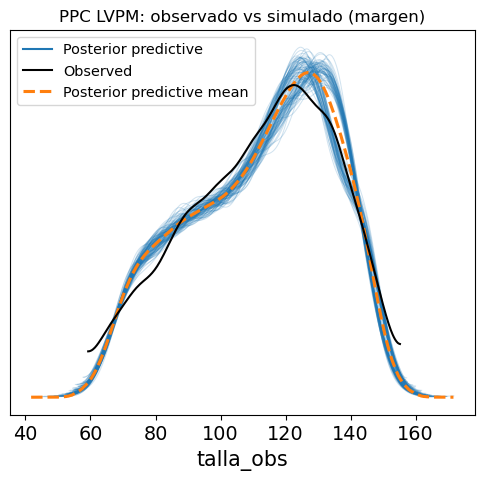

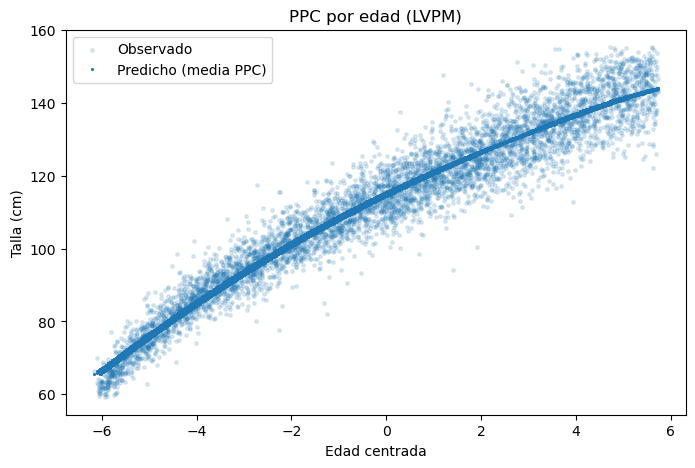

In [ ]:

# ======================================================
# LVPM (K=2: PRE/POST) + PPC dentro del mismo contexto
# ======================================================
with pm.Model() as modelo_lvpm:
    # -------------------------------
    # 1) Media "base" sin pubertad
    #    (intercepto + curvatura suave con edad)
    # -------------------------------
    beta_0 = pm.Normal("beta_0", 120, 10)         # talla media aprox.
    b_ed   = pm.Normal("b_ed",  20,  5)           # subida con la edad (lineal)
    b_ed2  = pm.Normal("b_ed2",  0,  5)           # curvatura global (opcional; ~0 si no hace falta)
    b_sx   = pm.Normal("b_sx",   1,  2)           # diferencia por sexo (nivel)

    mu_base = (
        beta_0
        + b_ed  * edad_c_sub
        + b_ed2 * (edad_c_sub**2)
        + b_sx  * sexo_sub
    )
    # Nota: si no quieres el término cuadrático, deja b_ed2 en 0 o quítalo.

    # -------------------------------
    # 2) Compuerta (probabilidad de POST)
    #    p_post = sigmoid(g0 + g_ed * edad_cs_sub + g_sx * sexo)
    # -------------------------------
    g0   = pm.Normal("g0",  0, 2)
    g_ed = pm.Normal("g_ed", 1.5, 1)     # debería salir >0 (a mayor edad, mayor prob POST)
    g_sx = pm.Normal("g_sx", 0, 1)

    logit_post = g0 + g_ed*edad_cs_sub + g_sx*sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))
    # Pesos por observación (fila): [Prob(PRE), Prob(POST)]
    W = pm.Deterministic("W", pm.math.stack([1 - p_post, p_post], axis=1))

    # -------------------------------
    # 3) Desplazamientos por estado (suma cero)
    #    Evita duplicar intercepto: delta[0] + delta[1] = 0
    # -------------------------------
    delta_raw = pm.Normal("delta_raw", 0, 5, shape=2)
    delta     = pm.Deterministic("delta", delta_raw - delta_raw.mean())

    # Medias por estado (n_obs x 2): PRE y POST
    mu_comp = pm.Deterministic(
        "mu_comp",
        pm.math.stack([mu_base + delta[0],   # PRE
                       mu_base + delta[1]],  # POST
                      axis=1)
    )

    # -------------------------------
    # 4) Likelihood robusta (mezcla de 2 Student-t)
    # -------------------------------
    nu    = pm.Exponential("nu", 1/10)         # g.l. (colas)
    sigma = pm.HalfNormal("sigma_obs", 5)      # desviación (cm)

    comp_pre  = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 0], sigma=sigma)
    comp_post = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 1], sigma=sigma)

    talla_obs = pm.Mixture(
        "talla_obs",
        w=W,                         # pesos por observación
        comp_dists=[comp_pre, comp_post],
        observed=y_sub
    )

    # -------------------------------
    # 5) MUESTREO + PPC aquí mismo
    # -------------------------------
    idata_lvpm = pm.sample(
        draws=1000, tune=1000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    # <- PPC dentro del contexto del modelo
    ppc_lvpm = pm.sample_posterior_predictive(
        idata_lvpm, return_inferencedata=True, random_seed=42
    )

# Adjuntar el PPC al InferenceData
idata_lvpm.extend(ppc_lvpm)

# ======================================================
# 6) Gráficas PPC (margen y por edad)
# ======================================================

# 6a) Overlay marginal observado vs simulado (densidades)
az.plot_ppc(
    idata_lvpm,
    kind="kde",
    data_pairs={"talla_obs": "talla_obs"},
    num_pp_samples=100,
    figsize=(6,5)
)
plt.title("PPC LVPM: observado vs simulado (margen)")
plt.show()

# 6b) Curva predicha por edad (promedio de simulaciones por observación)
y_ppc_mean = (
    idata_lvpm.posterior_predictive["talla_obs"]
    .mean(dim=("chain","draw"))
    .values
)

ord = np.argsort(edad_c_sub)
plt.figure(figsize=(8,5))
plt.scatter(edad_c_sub, y_sub, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c_sub[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.xlabel("Edad centrada")
plt.ylabel("Talla (cm)")
plt.legend()
plt.title("PPC por edad (LVPM)")
plt.show()

# ======================================================
# === Resumen del LVPM ===
az.summary(
    idata_lvpm, 
    var_names=[
        "beta_0", "b_ed", "b_ed2", "b_sx",   # curva base
        "g0", "g_ed", "g_sx",                # compuerta puberal
        "delta",                             # diferencias PRE/POST
        "sigma_obs", "nu"                    # escala y colas
    ],
    round_to=3
)




In [23]:


# === Resumen del LVPM ===
az.summary(
    idata_lvpm, 
    var_names=[
        "beta_0", "b_ed", "b_ed2", "b_sx",   # curva base
        "g0", "g_ed", "g_sx",                # compuerta puberal
        "delta",                             # diferencias PRE/POST
        "sigma_obs", "nu"                    # escala y colas
    ],
    round_to=3
)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,115.340,3.813,111.157,119.459,1.895,0.005,6.146,112.566,1.736
b_ed,6.376,0.491,5.834,6.925,0.244,0.001,6.106,155.020,1.736
b_ed2,-0.294,0.079,-0.386,-0.203,0.039,0.000,6.130,128.935,1.733
b_sx,1.200,0.165,0.913,1.525,0.003,0.004,2595.433,2189.870,1.014
g0,-2.967,0.737,-4.006,-1.907,0.350,0.006,6.137,163.582,1.737
g_ed,2.306,0.924,1.216,3.494,0.453,0.004,6.124,176.976,1.733
g_sx,-0.124,0.788,-1.148,0.911,0.385,0.003,6.133,177.304,1.734
delta[0],-0.574,4.438,-5.222,4.087,2.209,0.002,6.108,151.667,1.732
delta[1],0.574,4.438,-4.087,5.222,2.209,0.002,6.108,151.667,1.732
sigma_obs,4.370,0.084,4.216,4.527,0.013,0.001,40.014,523.882,1.073


---

### Metiendo splines

In [25]:
# =======================
# Construcción de Splines
# =======================

# Matriz de bases spline de edad (centrada)
X_s_sub = dmatrix(
    "bs(edad_c_sub, df=6, degree=3, include_intercept=False)",
    {"edad_c_sub": edad_c_sub},
    return_type="dataframe"
).to_numpy()

# Número de bases
n_s_sub = X_s_sub.shape[1]

print(f"Splines listos: X_s_sub con shape {X_s_sub.shape}, n_s_sub={n_s_sub}")


Splines listos: X_s_sub con shape (6000, 7), n_s_sub=7


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, b_sx, w_s, g0, g_ed, g_sx, d, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1338 seconds.
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

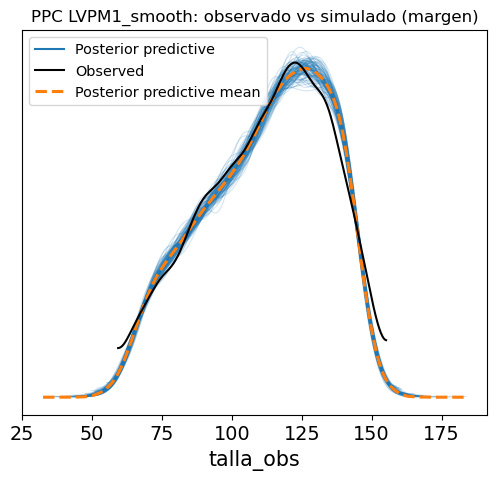

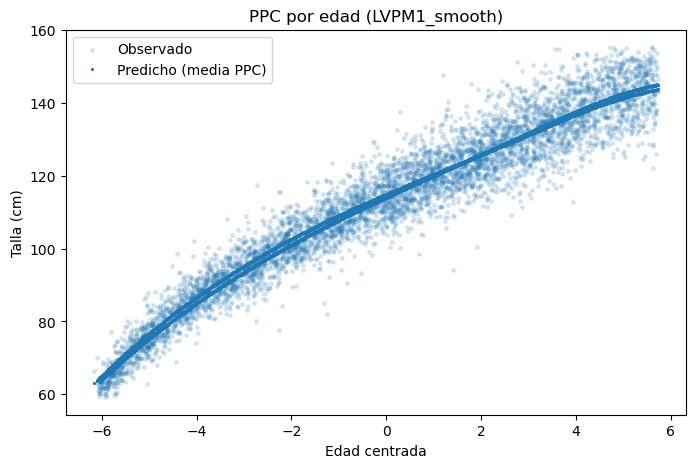

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,89.706,1.851,86.426,93.245,0.037,0.032,2447.853,2284.524,1.001
b_sx,-2.049,0.432,-2.830,-1.230,0.008,0.006,2758.506,2629.260,1.002
w_s[0],-0.294,0.991,-2.143,1.550,0.015,0.017,4156.498,2793.447,1.000
w_s[1],5.778,0.682,4.437,6.972,0.010,0.011,4391.558,3040.214,1.001
w_s[2],4.698,0.847,3.182,6.303,0.017,0.012,2578.206,2645.854,1.000
w_s[3],-3.641,0.834,-5.197,-2.086,0.016,0.013,2618.154,2315.691,1.000
w_s[4],-4.007,0.641,-5.251,-2.831,0.010,0.011,3768.597,2643.550,1.001
w_s[5],2.524,0.725,1.086,3.816,0.012,0.010,3454.414,3129.415,1.001
w_s[6],3.047,0.761,1.546,4.368,0.014,0.011,2991.671,3079.112,1.002
d,59.059,1.925,55.446,62.502,0.038,0.030,2613.394,2729.456,1.001


In [29]:
# ======================================================
# LVPM1_smooth: pubertad como desplazamiento SUAVE de la media (sin mezcla)
# ======================================================

ridge_sd = 1.0  # si ves ondulaciones en la curva de edad, baja a 0.5

with pm.Model() as modelo_lvpm1_smooth:
    # 1) Media base con splines + sexo
    beta_0 = pm.Normal("beta_0", 120, 10)
    b_sx   = pm.Normal("b_sx",    1,  2)

    w_s    = pm.Normal("w_s", 0, ridge_sd, shape=n_s_sub)
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))

    mu_base = beta_0 + b_sx * sexo_sub + f_edad

    # 2) Compuerta (probabilidad de post)
    g0   = pm.Normal("g0",   0,   2)
    g_ed = pm.Normal("g_ed", 1.5, 1)     # >0: p(post) sube con la edad
    g_sx = pm.Normal("g_sx", 0,   1)

    logit_post = g0 + g_ed * edad_cs_sub + g_sx * sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))

    # 3) Desplazamiento SUAVE: mu = mu_base + d*(2*p_post - 1)
    # d controla el "salto" total de PRE a POST (de -d a +d)
    d = pm.HalfNormal("d", 5)  # tamaño positivo; si quieres que pueda ser negativo, usa Normal(0,5)
    mu = pm.Deterministic("mu", mu_base + d * (2 * p_post - 1))

    # 4) Likelihood robusta (una sola Student-t → ¡adiós bimodalidad!)
    nu    = pm.Exponential("nu", 1/10)
    sigma = pm.HalfNormal("sigma_obs", 5)

    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y_sub)

    # 5) Muestreo + PPC
    idata_lvpm1_smooth = pm.sample(
        draws=1000, tune=1000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    ppc_lvpm1_smooth = pm.sample_posterior_predictive(
        idata_lvpm1_smooth, return_inferencedata=True, random_seed=42
    )

# Anexar PPC
idata_lvpm1_smooth.extend(ppc_lvpm1_smooth)

# ========== Gráficas ==========
# Marginal: debe salir UNImodal
az.plot_ppc(
    idata_lvpm1_smooth,
    kind="kde",
    data_pairs={"talla_obs": "talla_obs"},
    num_pp_samples=100,
    figsize=(6,5),
)
plt.title("PPC LVPM1_smooth: observado vs simulado (margen)")
plt.show()

# Por edad (media PPC)
y_ppc_mean = (
    idata_lvpm1_smooth.posterior_predictive["talla_obs"]
    .mean(dim=("chain","draw"))
    .values
)

ord = np.argsort(edad_c_sub)
plt.figure(figsize=(8,5))
plt.scatter(edad_c_sub, y_sub, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c_sub[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
plt.legend(); plt.title("PPC por edad (LVPM1_smooth)")
plt.show()

# Resumen
az.summary(
    idata_lvpm1_smooth,
    var_names=["beta_0","b_sx","w_s","d","g0","g_ed","g_sx","sigma_obs","nu"],
    round_to=3
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, b_sx, b_ed2, w_s, g0, g_ed, g_sx, delta, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1063 seconds.
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

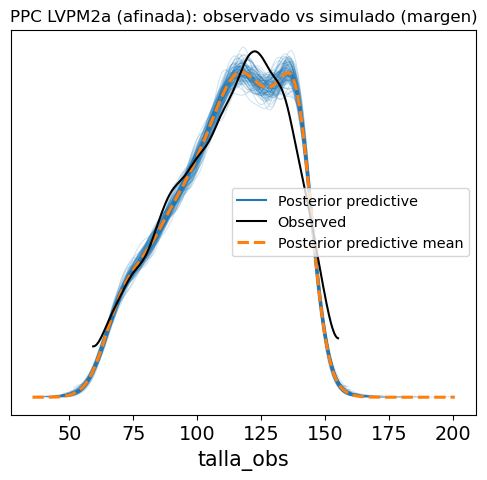

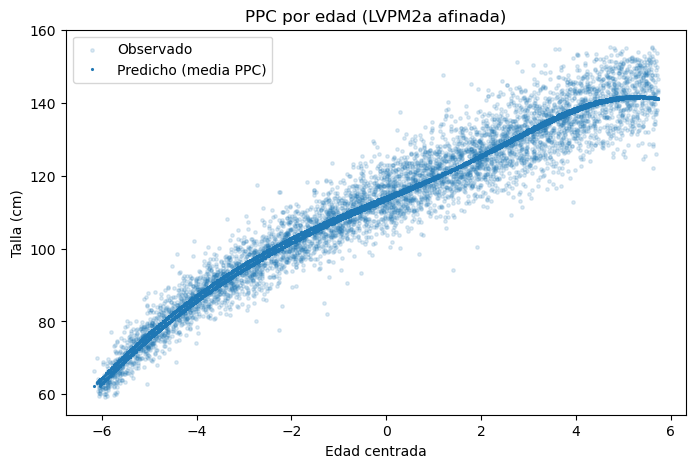

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,148.735,0.786,147.312,150.251,0.017,0.012,2120.517,2674.434,1.001
b_sx,1.556,0.215,1.130,1.932,0.004,0.003,3198.552,3325.392,1.001
b_ed2,-1.112,0.017,-1.145,-1.081,0.000,0.000,1937.417,2548.969,1.001
w_s[0],0.028,0.298,-0.523,0.592,0.004,0.004,4779.914,2931.203,1.000
w_s[1],-0.203,0.279,-0.726,0.311,0.004,0.004,5204.665,2691.862,1.001
w_s[2],-0.629,0.296,-1.149,-0.046,0.006,0.004,2690.325,2573.236,1.000
w_s[3],0.970,0.273,0.431,1.462,0.004,0.004,4355.935,3399.075,1.001
w_s[4],-0.420,0.308,-1.032,0.121,0.005,0.005,3227.013,2913.113,1.000
w_s[5],-0.499,0.286,-1.018,0.044,0.004,0.005,4475.765,2777.346,1.002
w_s[6],1.252,0.295,0.689,1.783,0.005,0.005,3858.216,3064.978,1.001


In [30]:
# ======================================================
# LVPM2a (afinado): splines + curvatura global + delta contenido + PPC
# ======================================================

ridge_sd = 0.3   # más pequeño => curva spline más suave (prueba 0.3–0.5)

with pm.Model() as modelo_lvpm2a:
    # ---------- 1) Media base: intercepto + sexo + edad (cuadrática) + spline suave ----------
    beta_0 = pm.Normal("beta_0", 120, 10)
    b_sx   = pm.Normal("b_sx",    1,   2)
    b_ed2  = pm.Normal("b_ed2",   0,   2)   # curvatura global (suave)

    # >>> si ya generaste una base reducida, usa X_s_sub_red y su shape <<<
    w_s    = pm.Normal("w_s", 0, ridge_sd, shape=X_s_sub.shape[1])
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))

    mu_base = beta_0 + b_sx * sexo_sub + b_ed2 * (edad_c_sub**2) + f_edad

    # ---------- 2) Compuerta puberal (logística) ----------
    g0   = pm.Normal("g0",   0,   2)
    g_ed = pm.Normal("g_ed", 1.5, 1)   # debería salir > 0
    g_sx = pm.Normal("g_sx", 0,   1)

    logit_post = g0 + g_ed * edad_cs_sub + g_sx * sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))

    # ---------- 3) Desplazamiento SUAVE por pubertad ----------
    # Delta interpretable y contenido (permite +/-): PRE≈ -|delta|, POST≈ +|delta| si se ordena así.
    delta = pm.Normal("delta", 0, 2)   # más informativo que HalfNormal(5)
    mu    = pm.Deterministic("mu", mu_base + delta * (2 * p_post - 1))

    # ---------- 4) Likelihood robusta (un solo Student-t) ----------
    nu    = pm.Exponential("nu", 1/10)
    sigma = pm.HalfNormal("sigma_obs", 5)
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y_sub)

    # ---------- 5) Muestreo + PPC ----------
    idata_lvpm2a = pm.sample(
        draws=1000, tune=1000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
    )
    ppc_lvpm2a = pm.sample_posterior_predictive(
        idata_lvpm2a, return_inferencedata=True, random_seed=42
    )

# Adjunta PPC
idata_lvpm2a.extend(ppc_lvpm2a)

# ---------- PPC marginal ----------
az.plot_ppc(
    idata_lvpm2a,
    kind="kde",
    data_pairs={"talla_obs": "talla_obs"},
    num_pp_samples=100,
    figsize=(6,5),
)
plt.title("PPC LVPM2a (afinada): observado vs simulado (margen)")
plt.show()

# ---------- PPC por edad ----------
y_ppc_mean = (
    idata_lvpm2a.posterior_predictive["talla_obs"]
    .mean(dim=("chain","draw"))
    .values
)
ord = np.argsort(edad_c_sub)
plt.figure(figsize=(8,5))
plt.scatter(edad_c_sub, y_sub, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c_sub[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
plt.legend(); plt.title("PPC por edad (LVPM2a afinada)")
plt.show()

# ---------- Resumen ----------
az.summary(
    idata_lvpm2a,
    var_names=["beta_0","b_sx","b_ed2","w_s","delta","g0","g_ed","g_sx","sigma_obs","nu"],
    round_to=3
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, b_sx, b_ed2, w_s, g0, g_ed, g_sx, delta, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 720 seconds.
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

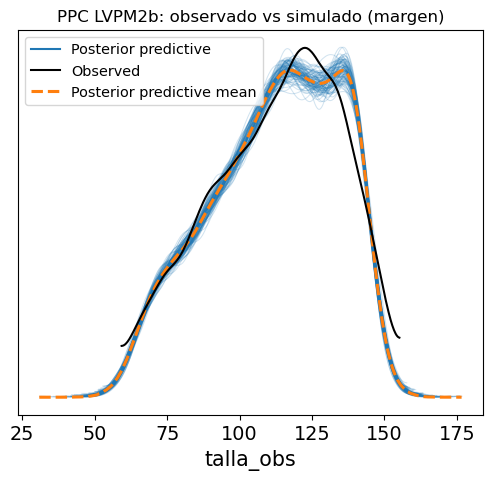

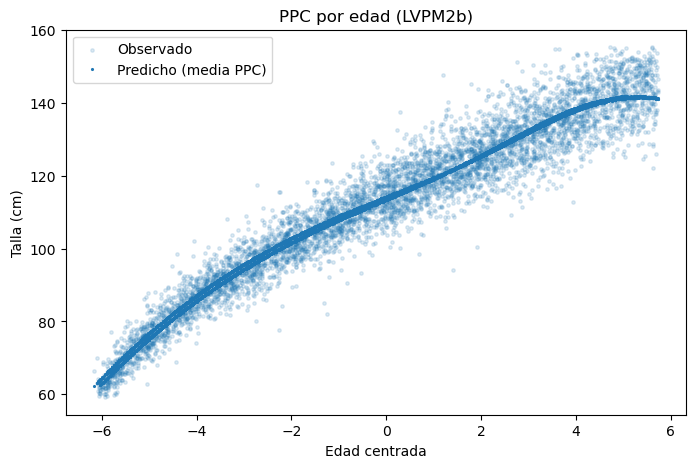

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,148.742,0.780,147.236,150.131,0.016,0.013,2330.957,2388.513,1.001
b_sx,1.548,0.215,1.148,1.944,0.004,0.003,2913.648,2620.808,1.002
b_ed2,-1.111,0.017,-1.143,-1.080,0.000,0.000,1879.814,2766.648,1.002
w_s[0],0.021,0.298,-0.519,0.586,0.004,0.005,4540.582,3062.381,1.002
w_s[1],-0.199,0.278,-0.729,0.306,0.004,0.004,4462.357,3074.306,1.001
w_s[2],-0.620,0.296,-1.139,-0.050,0.005,0.004,3040.762,3017.334,1.001
w_s[3],0.973,0.274,0.457,1.480,0.004,0.004,3889.070,3251.707,1.001
w_s[4],-0.427,0.303,-1.050,0.100,0.005,0.006,3316.853,2331.698,1.000
w_s[5],-0.493,0.285,-0.996,0.085,0.004,0.005,4161.008,2960.566,1.000
w_s[6],1.247,0.298,0.692,1.811,0.005,0.005,4317.676,2837.149,1.001


In [31]:
# ======================================================
# LVPM2b (suave): pubertad como desplazamiento gradual
# ======================================================

ridge_sd = 0.3   # splines más contenidos → curva de edad más suave

with pm.Model() as modelo_lvpm2b:
    # 1) Media base: intercepto + sexo + curva no lineal (splines) + curvatura global
    beta_0 = pm.Normal("beta_0", 120, 10)     # nivel medio
    b_sx   = pm.Normal("b_sx",    0,  2)      # diferencia por sexo (nivel)
    b_ed2  = pm.Normal("b_ed2",   0,  2)      # curvatura global (opcional, suave)

    # Splines: pesos con regularización fuerte para evitar ondulaciones
    w_s    = pm.Normal("w_s", 0, ridge_sd, shape=n_s_sub)
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))

    mu_base = beta_0 + b_sx * sexo_sub + f_edad + b_ed2 * (edad_c_sub**2)

    # 2) Compuerta puberal (probabilidad de POST)
    g0   = pm.Normal("g0",   0,   2)
    g_ed = pm.Normal("g_ed", 1.5, 1)      # debe salir > 0
    g_sx = pm.Normal("g_sx", 0,   1)

    logit_post = g0 + g_ed * edad_cs_sub + g_sx * sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))

    # 3) Desplazamiento SUAVE PRE→POST (simétrico)
    #    p_post=0 → -delta ; p_post=1 → +delta ; p_post=0.5 → 0
    delta = pm.Normal("delta", 0, 2)
    mu    = pm.Deterministic("mu", mu_base + delta * (2 * p_post - 1))

    # 4) Likelihood robusta (una sola Student-t → unimodal)
    nu    = pm.Exponential("nu", 1/10)
    sigma = pm.HalfNormal("sigma_obs", 5)

    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y_sub)

    # 5) Muestreo + PPC
    idata_lvpm2b = pm.sample(
        draws=1000, tune=1000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    ppc_lvpm2b = pm.sample_posterior_predictive(
        idata_lvpm2b, return_inferencedata=True, random_seed=42
    )

# Adjunta PPC
idata_lvpm2b.extend(ppc_lvpm2b)

# ========== Gráficas (margen y por edad) ==========
az.plot_ppc(
    idata_lvpm2b,
    kind="kde",
    data_pairs={"talla_obs": "talla_obs"},
    num_pp_samples=100,
    figsize=(6,5),
)
plt.title("PPC LVPM2b: observado vs simulado (margen)")
plt.show()

y_ppc_mean = (
    idata_lvpm2b.posterior_predictive["talla_obs"]
    .mean(dim=("chain","draw"))
    .values
)

ord = np.argsort(edad_c_sub)
plt.figure(figsize=(8,5))
plt.scatter(edad_c_sub, y_sub, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c_sub[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
plt.legend(); plt.title("PPC por edad (LVPM2b)")
plt.show()

# === Resumen de parámetros clave ===
az.summary(
    idata_lvpm2b,
    var_names=["beta_0","b_sx","b_ed2","w_s","delta","g0","g_ed","g_sx","sigma_obs","nu"],
    round_to=3
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, b_sx, w_s, b_ed2, b_ed3, g0, g_ed, g_sx, d, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13676 seconds.
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

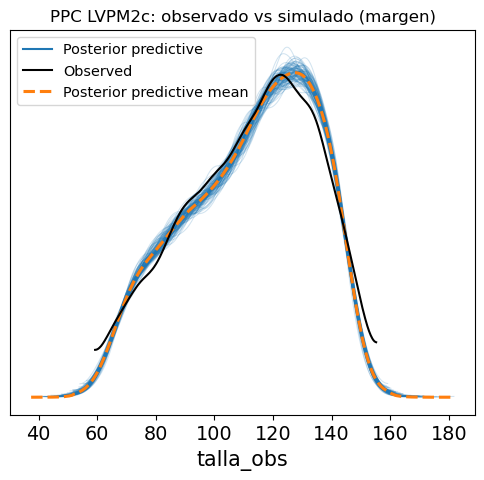

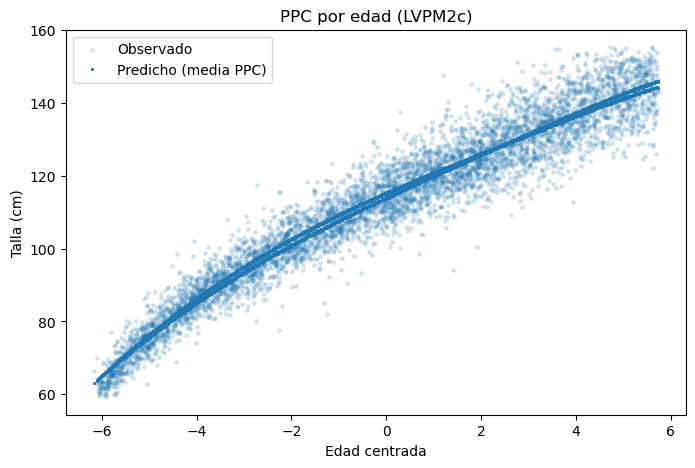

Computed from 4000 posterior samples and 6000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -18665.60    64.20
p_loo        9.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     6000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


Pareto-k:  k>0.7 = 0  |  k>1.0 = 0  de 6000


In [32]:
# ================================
# LVPM2c: splines (ridge bajo) + polinomio cúbico suave + compuerta puberal
# ================================

# 0) Pequeño re-escalado para los términos polinomiales (estabilidad de priors)
edad_c_s = edad_c_sub / 5.0   # si edad_c_sub ~ [-6,6], ahora queda ~[-1.2,1.2]

ridge_sd = 0.5   # ↓ regularización spline (más suave que 1.0)

with pm.Model() as modelo_lvpm2c:
    # 1) Media base: intercepto + diferencia por sexo + curva suave por edad (splines)
    beta_0 = pm.Normal("beta_0", 120, 10)
    b_sx   = pm.Normal("b_sx",    1,   2)

    w_s    = pm.Normal("w_s", 0, ridge_sd, shape=n_s_sub)           # pesos spline más contenidos
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))  # curva suave por edad

    # 1b) Curvatura global adicional (polinomio SUAVE en edad centrada y re-escalada)
    b_ed2 = pm.Normal("b_ed2", 0, 1.0)     # cuadrático (suave)
    b_ed3 = pm.Normal("b_ed3", 0, 0.5)     # cúbico (más apretado para evitar overfit)

    mu_base = (
        beta_0
        + b_sx * sexo_sub
        + f_edad
        + b_ed2 * (edad_c_s**2)
        + b_ed3 * (edad_c_s**3)
    )

    # 2) Compuerta puberal (probabilidad de POST)
    g0   = pm.Normal("g0",   0,   2)
    g_ed = pm.Normal("g_ed", 1.5, 1)      # >0: la prob de POST sube con la edad
    g_sx = pm.Normal("g_sx", 0,   1)

    logit_post = g0 + g_ed * edad_cs_sub + g_sx * sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))

    # 3) Desplazamiento puberal SUAVE (sin mezcla): de -d (PRE) a +d (POST)
    d  = pm.HalfNormal("d", 3)             # un poco más contenido que 5
    mu = pm.Deterministic("mu", mu_base + d * (2*p_post - 1))

    # 4) Likelihood robusta (una sola Student-t → unimodal)
    nu    = pm.Exponential("nu", 1/10)
    sigma = pm.HalfNormal("sigma_obs", 5)
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y_sub)

    # 5) Muestreo + PPC
    idata_lvpm2c = pm.sample(
        draws=1000, tune=1000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )
    ppc_lvpm2c = pm.sample_posterior_predictive(
        idata_lvpm2c, return_inferencedata=True, random_seed=42
    )

# Adjunta PPC al idata
idata_lvpm2c.extend(ppc_lvpm2c)

# ================================
# Gráficas PPC
# ================================
# (A) Marginal (debe verse unimodal y pegado a la negra)
az.plot_ppc(
    idata_lvpm2c, kind="kde",
    data_pairs={"talla_obs":"talla_obs"},
    num_pp_samples=100, figsize=(6,5)
)
plt.title("PPC LVPM2c: observado vs simulado (margen)")
plt.show()

# (B) Por edad (media PPC por observación)
y_ppc_mean = (
    idata_lvpm2c.posterior_predictive["talla_obs"]
    .mean(dim=("chain","draw")).values
)
ord = np.argsort(edad_c_sub)
plt.figure(figsize=(8,5))
plt.scatter(edad_c_sub, y_sub, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c_sub[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
plt.legend(); plt.title("PPC por edad (LVPM2c)")
plt.show()

# ================================
# Resumen y validación
# ================================
az.summary(
    idata_lvpm2c,
    var_names=["beta_0","b_sx","w_s","b_ed2","b_ed3","d","g0","g_ed","g_sx","sigma_obs","nu"],
    round_to=3
)

# LOO (y Pareto-k) para comparar luego con otros modelos (M5, LVPM2b, etc.)
loo_lvpm2c = az.loo(idata_lvpm2c, pointwise=True)
print(loo_lvpm2c)

kvals = loo_lvpm2c.pareto_k.values
print("\nPareto-k:  k>0.7 =", (kvals>0.7).sum(), " |  k>1.0 =", (kvals>1.0).sum(), " de", kvals.size)
